In [1]:
from numpy import genfromtxt

bands = genfromtxt('./helpers/bands.csv', delimiter=',')

In [2]:
leaf_pixel_x = 25
leaf_pixel_y = 25
start_band = 110
end_band = 135
band_delta = end_band - start_band
band_range = bands[start_band:end_band]

In [3]:
import numpy as np
import matplotlib.pyplot as plt

results_dir = "results/"

rois_old = np.empty((6, 50, 50, band_delta))
for i in range(1, 4):
    current_rois = np.load("{}rois_old{}.npy".format(results_dir, i))
    current_rois = current_rois[..., start_band:end_band]
    rois_old = np.append(rois_old, current_rois, axis=0)

rois_old = np.delete(rois_old, np.s_[0:6], axis=0)
rois_old.shape

(18, 50, 50, 25)

In [4]:
rois_young = np.empty((6, 50, 50, band_delta))
for i in range(1, 4):
    current_rois = np.load("{}rois_young{}.npy".format(results_dir, i))
    current_rois = current_rois[..., start_band:end_band]
    rois_young = np.append(rois_young, current_rois, axis=0)

rois_young = np.delete(rois_young, np.s_[0:6], axis=0)
rois_young.shape

(18, 50, 50, 25)

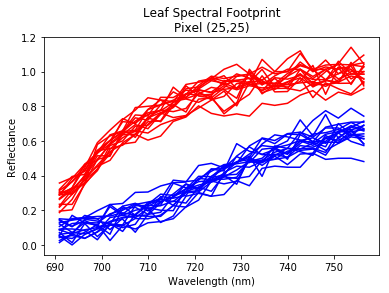

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)

for i in range(1, rois_young.shape[0]):
    leaf_pixel = rois_old[i, leaf_pixel_x, leaf_pixel_y, :]
    leaf_pixel_squeezed = np.squeeze(leaf_pixel)
    ax.plot(band_range, leaf_pixel_squeezed, 'b')
    
    leaf_pixel = rois_young[i, leaf_pixel_x, leaf_pixel_y, :]
    leaf_pixel_squeezed = np.squeeze(leaf_pixel)
    ax.plot(band_range, leaf_pixel_squeezed ,'r')

plt.title('Leaf Spectral Footprint\nPixel ({},{})'.format(
    leaf_pixel_x, leaf_pixel_y))
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.show([-100, 100])

In [6]:
from sklearn.model_selection import train_test_split

X = np.append(rois_old, rois_young, axis=0)
y = np.append(np.ones(18), np.zeros(18))

# train size 5/6 or ~83.3%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/6)

X.shape, y.shape

((36, 50, 50, 25), (36,))

In [7]:
from keras.utils import to_categorical
# one-hot encode target column
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

Using TensorFlow backend.


In [8]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape = (50, 50, band_delta), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(32, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Flatten())
model.add(Dense(units = 128, activation = 'relu'))
model.add(Dense(units = 2, activation = 'sigmoid'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
from time import time
from keras.callbacks import TensorBoard

tensorboard = TensorBoard(log_dir="../../logs/{}".format(time()))

In [10]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, callbacks=[tensorboard])

Train on 30 samples, validate on 6 samples
Epoch 1/20
30/30 [==============================] - 3s 107ms/step - loss: 0.6786 - acc: 0.5000 - val_loss: 0.9171 - val_acc: 0.5000
Epoch 2/20
30/30 [==============================] - 0s 1ms/step - loss: 0.9302 - acc: 0.5000 - val_loss: 0.6772 - val_acc: 0.5000
Epoch 3/20
30/30 [==============================] - 0s 554us/step - loss: 0.6717 - acc: 0.5000 - val_loss: 0.6784 - val_acc: 0.5000
Epoch 4/20
30/30 [==============================] - 0s 697us/step - loss: 0.6738 - acc: 0.5000 - val_loss: 0.6512 - val_acc: 0.5000
Epoch 5/20
30/30 [==============================] - 0s 534us/step - loss: 0.6473 - acc: 0.5000 - val_loss: 0.6351 - val_acc: 1.0000
Epoch 6/20
30/30 [==============================] - 0s 567us/step - loss: 0.6322 - acc: 1.0000 - val_loss: 0.6181 - val_acc: 1.0000
Epoch 7/20
30/30 [==============================] - 0s 584us/step - loss: 0.6150 - acc: 1.0000 - val_loss: 0.5750 - val_acc: 1.0000
Epoch 8/20
30/30 [=================

In [11]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 2.5819797883741558e-05
Test accuracy: 1.0


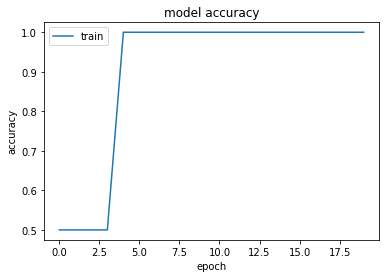

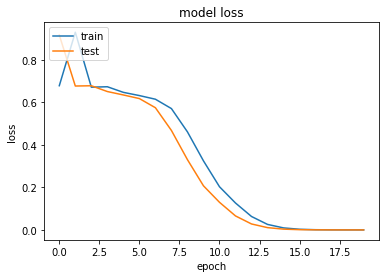

In [12]:
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [13]:
model.predict(X_test[:])

array([[6.4517260e-02, 6.5565109e-07],
       [8.8274479e-05, 8.0705309e-01],
       [1.1793342e-01, 3.2782555e-07],
       [1.8715858e-05, 8.6019176e-01],
       [7.5995922e-06, 9.1560835e-01],
       [1.0560098e-01, 2.6822090e-07]], dtype=float32)

In [14]:
y_test[:]

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)